### Dependencies loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import os
import graphviz
from IPython.display import display
from sklearn.tree import export_graphviz
os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"
pd.set_option('display.max_columns', 500)

C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("../data/train.csv", index_col=0)
df_test = pd.read_csv("../data/test.csv",index_col=0)

## Feature engineering

### Feature engineering during ETL

This procedure was applied during data preparation process in the previous notebook.

### Feature engineering after ETL

We will split this chapter into two parts: 
* one dimensional approach
* time-series approach

#### FE - one dimensional approach

In [3]:
def quick_viz(x):
    plt.figure(figsize=(10, 5))
    sns.distplot(x, kde=False, bins=50)
    plt.plot()
    plt.figure(figsize=(10, 5))
    sns.boxplot(x)
    plt.plot()
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x, df.etr)
    plt.plot()

To be honest feature creation process is already half done  - dataset gather financial transformations. But we will consider some additional transformations, variable by variable!

We know that all variables till **roa** has *wild* distribution! They look like that more or less due to the fact that many companies are not publishing all data in financial statements, and in such a case 0 was inputted. 

**sektor**

Here let's apply just One Hot Encoding (drop first category to omit collinearity). In our opinion it's a bad idea to group them (high heterogeneity).

In [4]:
df = pd.get_dummies(df, columns=["sektor"], prefix=["sektor"], drop_first=True)

In [5]:
df_test = pd.get_dummies(df_test, columns=["sektor"], prefix=["sektor"], drop_first=True)

In [6]:
print(df.shape, df_test.shape)

(3993, 49) (363, 49)


**gielda**

Here let's apply just One Hot Encoding (drop first category to omit collinearity). In our opinion it's a bad idea to group them (high heterogeneity).

In [7]:
df = pd.get_dummies(df, columns=["gielda"], prefix=["gielda"], drop_first=True)

In [8]:
df_test = pd.get_dummies(df_test, columns=["gielda"], prefix=["gielda"], drop_first=True)

In [9]:
print(df.shape, df_test.shape)

(3993, 52) (363, 52)


**ta**

Literature suggests that logarithm of total assets can approximate size of a company. This impact is visible! What is more this variable seems to follow PowerLow Distribution

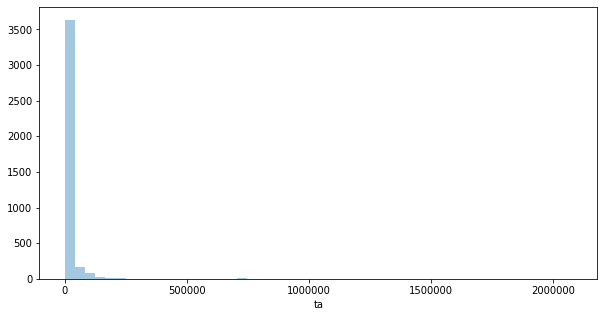

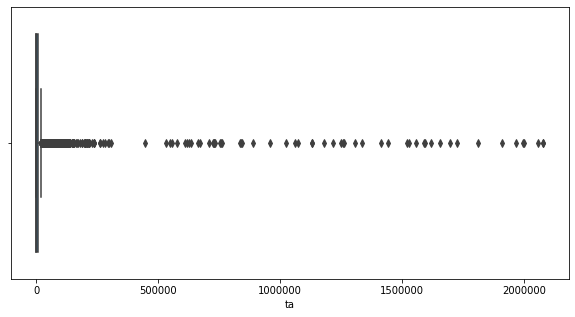

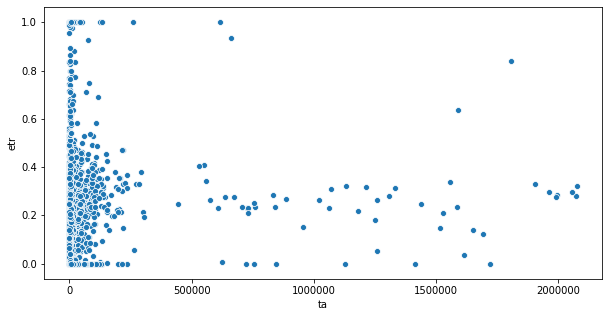

In [10]:
quick_viz(df.ta)

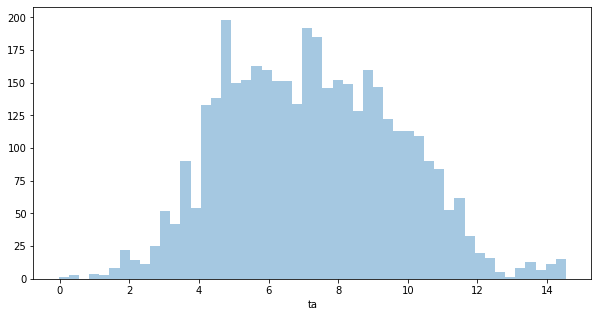

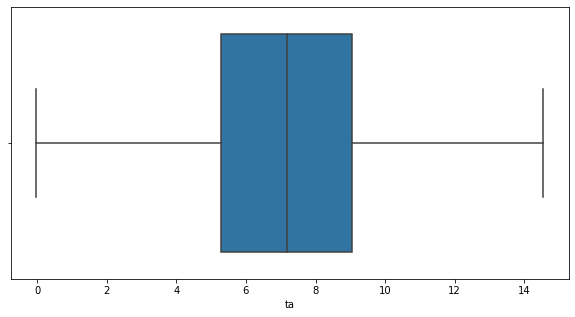

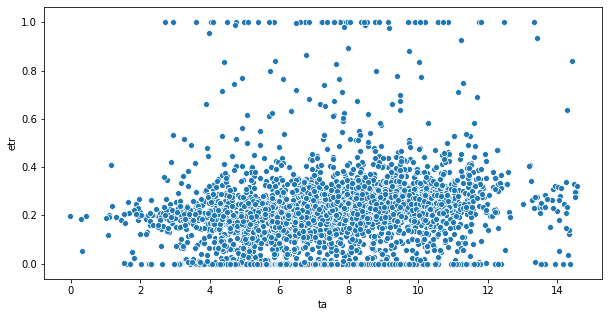

In [11]:
quick_viz(np.log(df.ta))

In [12]:
df["ta_log"] = np.log(df.ta)

In [13]:
df_test["ta_log"] = np.log(df_test.ta)

In [14]:
print(df.shape, df_test.shape)

(3993, 53) (363, 53)


**txt**

Here we can try to create bins. We will use decision-tree to obtain such results.

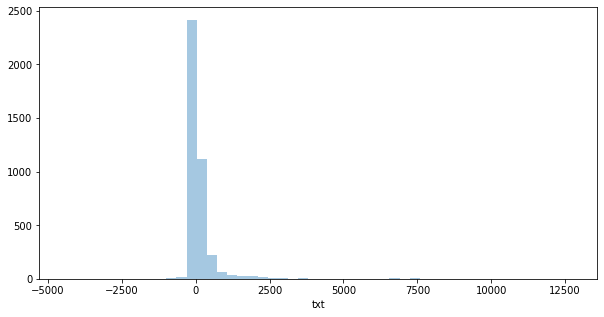

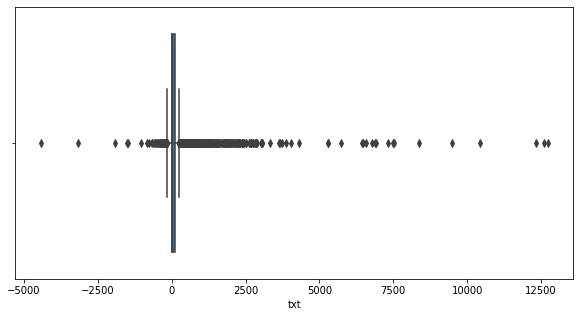

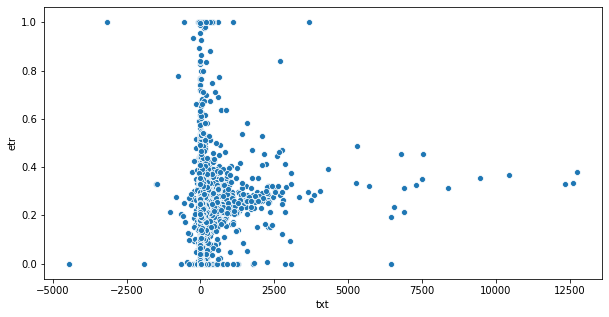

In [15]:
quick_viz(df["txt"])

We will try to obtain very shallow DT (to fight against overfitting)

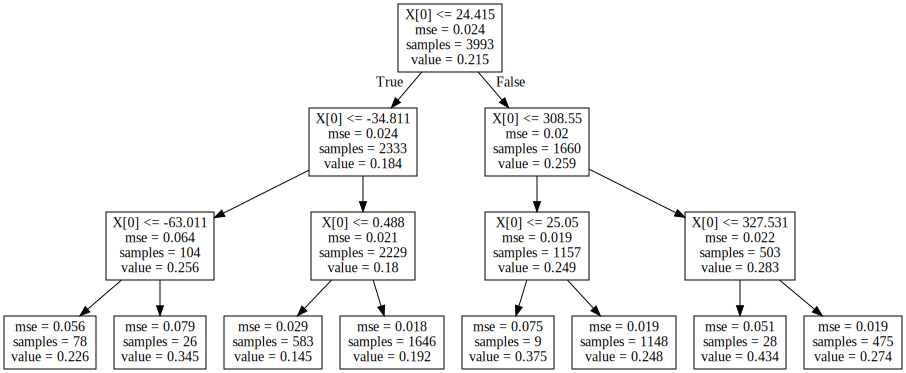

In [16]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(np.array(df.txt).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [17]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [18]:
df["txt_cat"] = pd.cut(df.txt,splits)
df_test["txt_cat"] = pd.cut(df_test.txt,splits)

In [19]:
df = pd.get_dummies(df, columns=["txt_cat"], prefix=["txt_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["txt_cat"], prefix=["txt_cat"], drop_first=True)

In [20]:
print(df.shape, df_test.shape)

(3993, 60) (363, 60)


**pi**

Let's apply the same approach as in case of txt

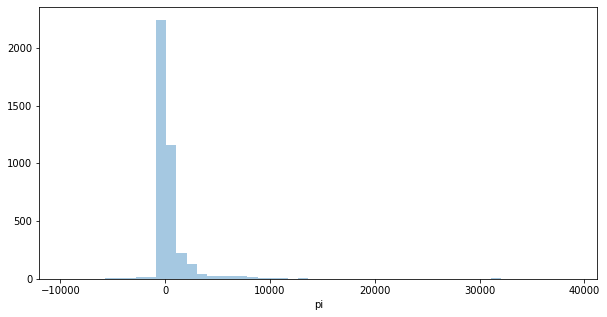

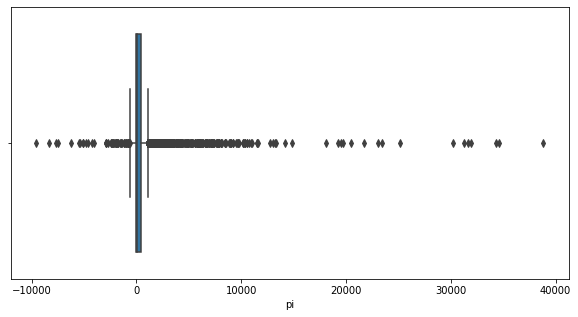

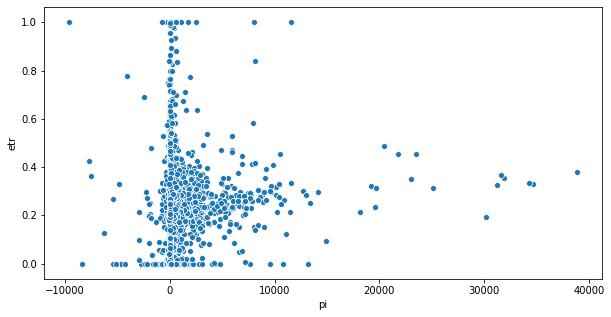

In [21]:
quick_viz(df["pi"])

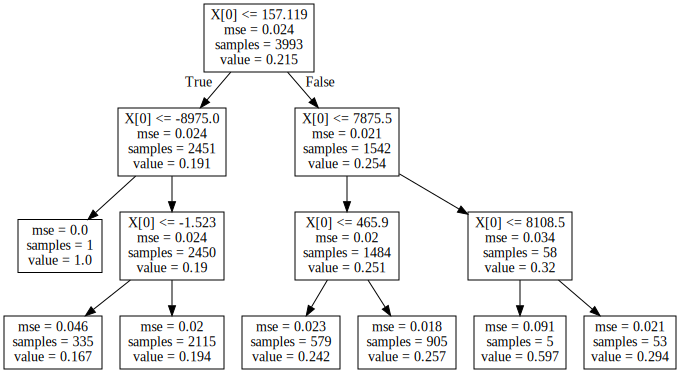

In [22]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(np.array(df["pi"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [23]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [24]:
df["pi_cat"] = pd.cut(df["pi"],splits)
df_test["pi_cat"] = pd.cut(df_test["pi"],splits)

In [25]:
df = pd.get_dummies(df, columns=["pi_cat"], prefix=["pi_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["pi_cat"], prefix=["pi_cat"], drop_first=True)

In [26]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 66) (363, 66)
True


**str** - let's discretize this variable

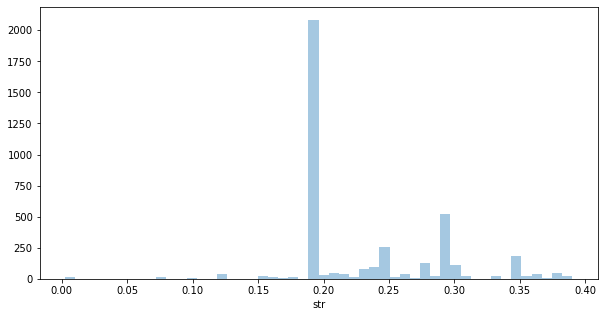

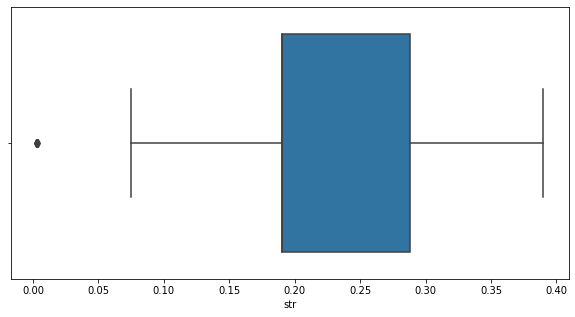

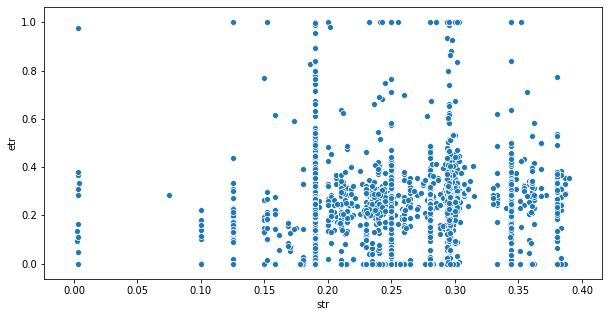

In [27]:
quick_viz((df["str"]))

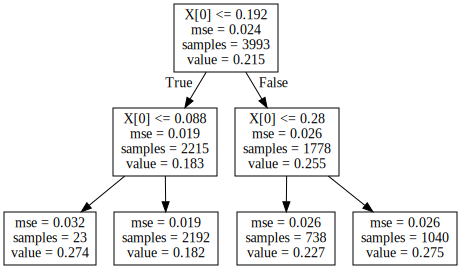

In [28]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["str"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [29]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [30]:
df["str_cat"] = pd.cut(df["str"],splits)
df_test["str_cat"] = pd.cut(df_test["str"],splits)

In [31]:
df = pd.get_dummies(df, columns=["str_cat"], prefix=["str_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["str_cat"], prefix=["str_cat"], drop_first=True)

In [32]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 69) (363, 69)
True


**xrd** - here we can check if company reports research and development expenditure (dichotomous variable)

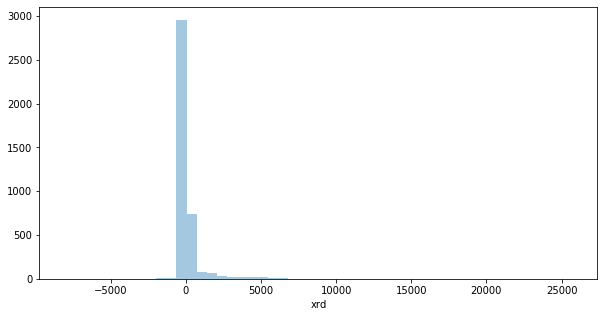

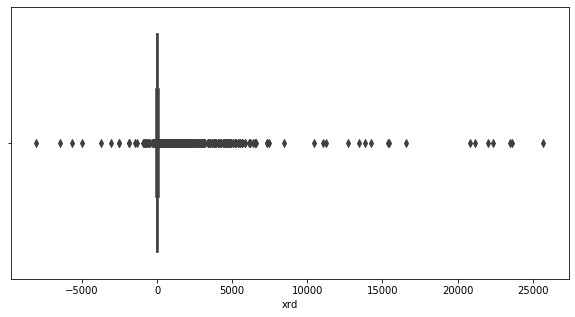

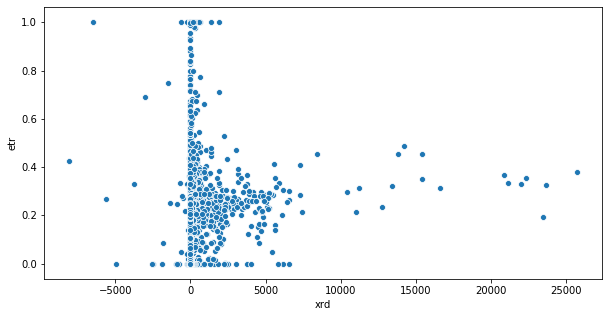

In [33]:
quick_viz(df.xrd)

In [34]:
df["xrd_exists"] = df.xrd != 0
df_test["xrd_exists"] = df_test.xrd != 0

In [35]:
df.xrd_exists.value_counts()

False    2623
True     1370
Name: xrd_exists, dtype: int64

In [36]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 70) (363, 70)
True


**ni** - dichotomous variable profit or loss

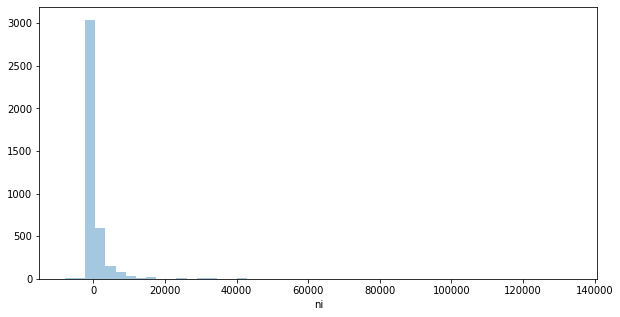

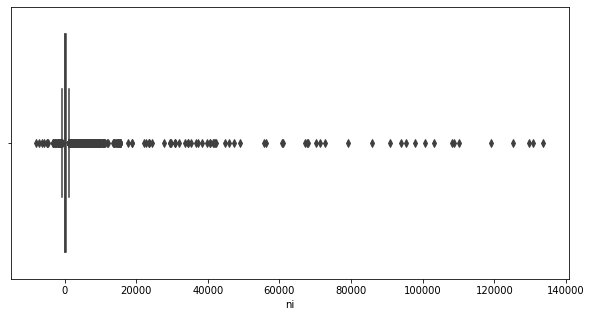

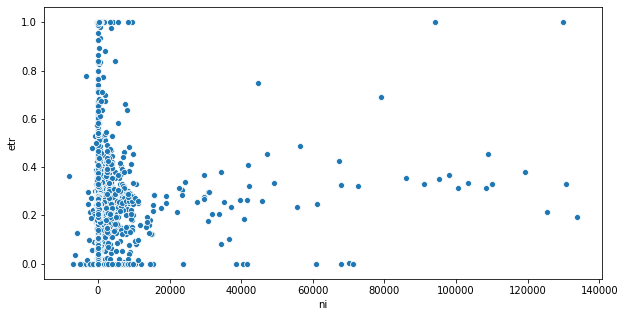

In [37]:
quick_viz(df.ni)

In [38]:
df["ni_profit"] = df.ni > 0 
df_test["ni_profit"] = df_test.ni > 0 

df["ni_profit_20000"] = df.ni > 20000
df_test["ni_profit_20000"] = df_test.ni > 20000

In [39]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 72) (363, 72)
True


**ppent** - let's apply sqrt here

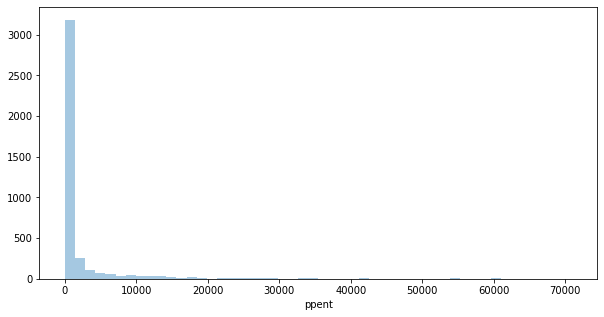

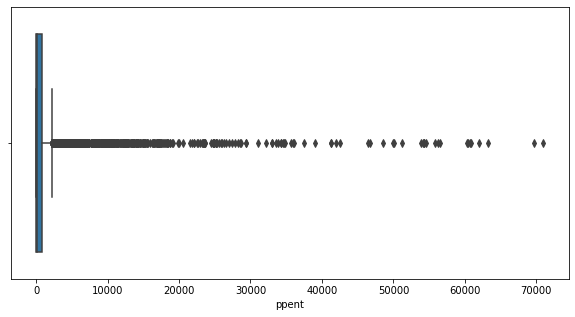

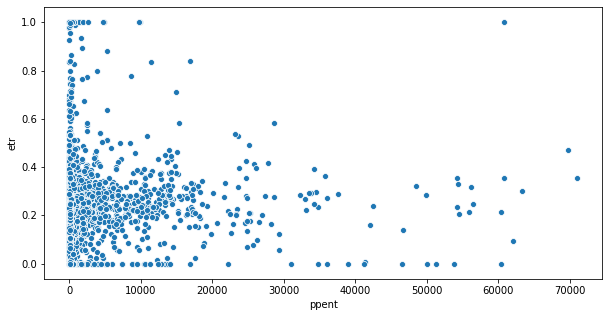

In [40]:
quick_viz(df.ppent)

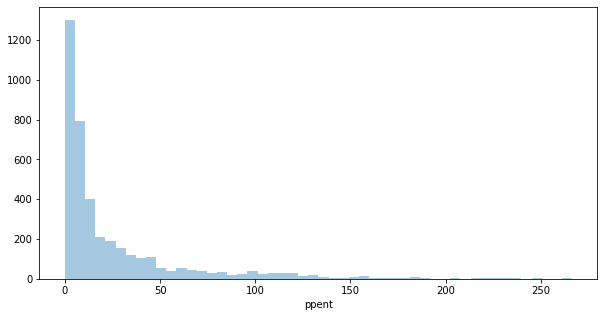

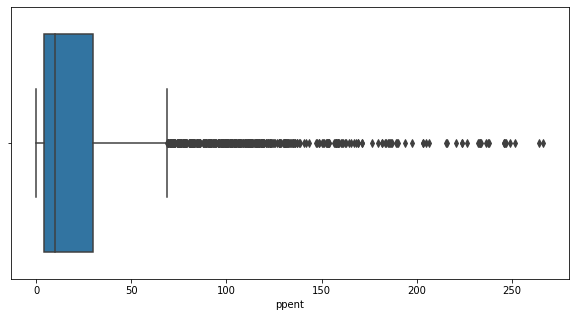

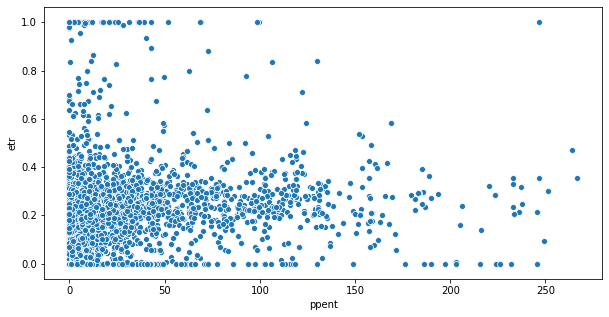

In [41]:
quick_viz(np.sqrt(df.ppent))

In [42]:
df["ppent_sqrt"] = np.sqrt(df.ppent)
df_test["ppent_sqrt"] = np.sqrt(df_test.ppent)

In [43]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 73) (363, 73)
True


**intant** - sqrt

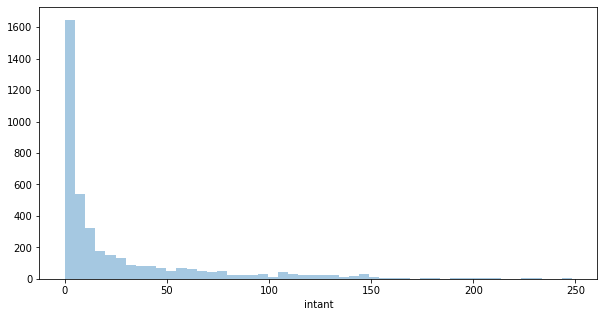

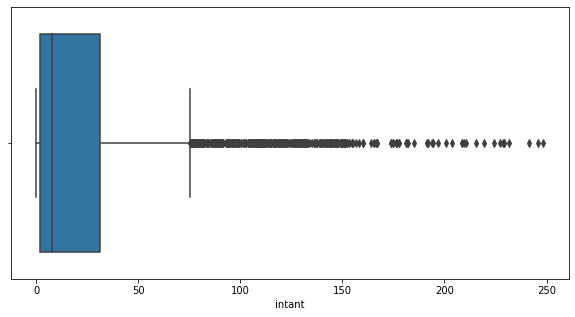

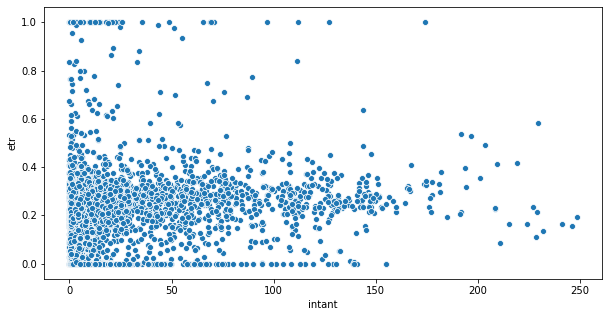

In [44]:
quick_viz(np.sqrt(df.intant))

In [45]:
df["intant_sqrt"] = np.sqrt(df.intant)
df_test["intant_sqrt"] = np.sqrt(df_test.intant)

In [46]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 74) (363, 74)
True


**dlc** - discretization using tree

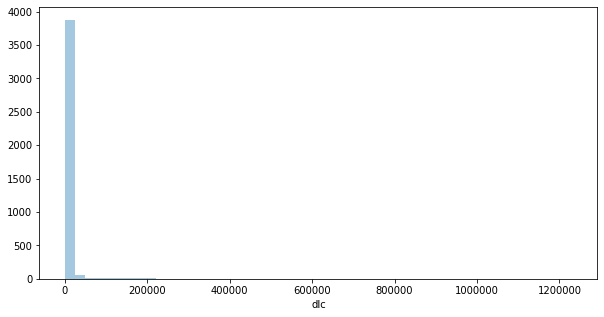

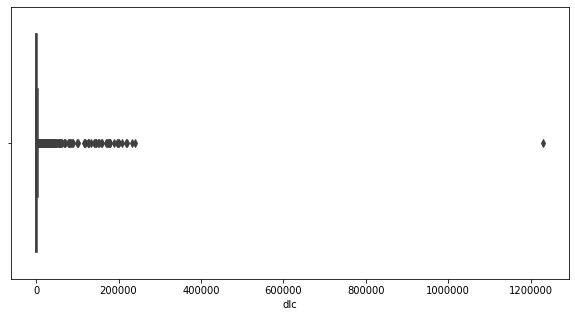

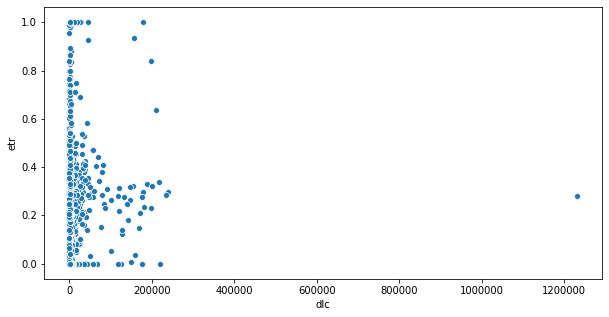

In [47]:
quick_viz(df.dlc)

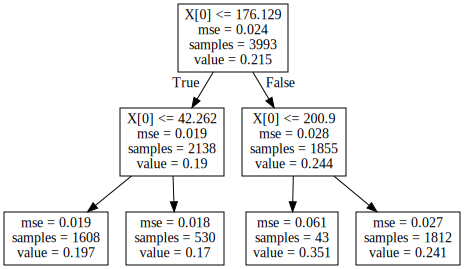

In [48]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["dlc"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [49]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [50]:
df["dlc_cat"] = pd.cut(df["dlc"],splits)
df_test["dlc_cat"] = pd.cut(df_test["dlc"],splits)

In [51]:
df = pd.get_dummies(df, columns=["dlc_cat"], prefix=["dlc_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["dlc_cat"], prefix=["dlc_cat"], drop_first=True)

In [52]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 77) (363, 77)
True


**dltt** - discretization using tree

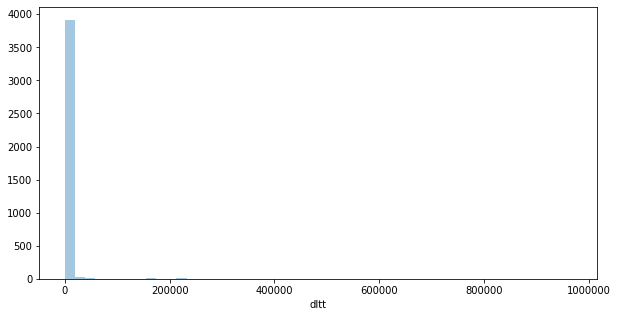

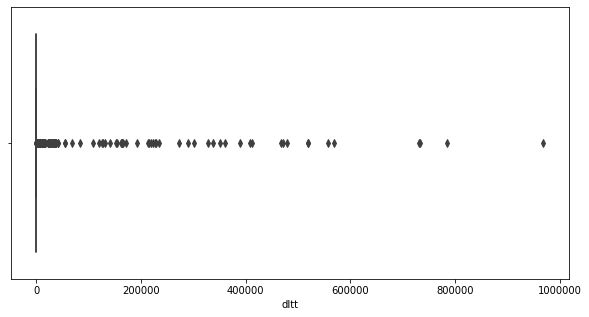

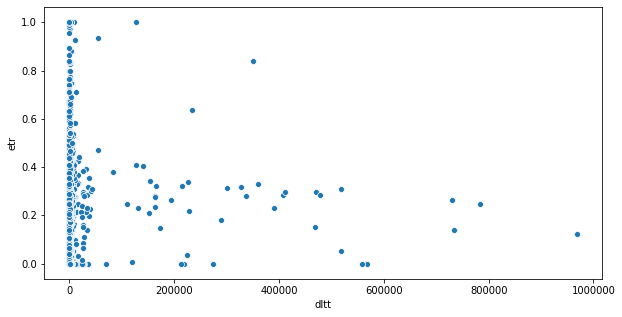

In [53]:
quick_viz(df.dltt)

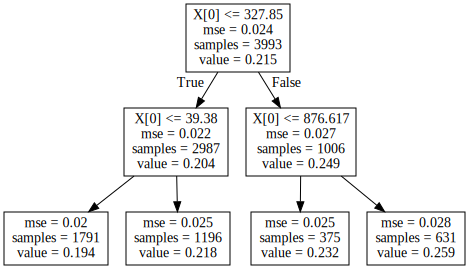

In [54]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["dltt"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [55]:
splits = np.array(clf.tree_.threshold)

splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [56]:
df["dltt_cat"] = pd.cut(df["dltt"],splits)
df_test["dltt_cat"] = pd.cut(df_test["dltt"],splits)

df = pd.get_dummies(df, columns=["dltt_cat"], prefix=["dltt_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["dltt_cat"], prefix=["dltt_cat"], drop_first=True)

In [57]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 80) (363, 80)
True


**capex** - discretization using tree

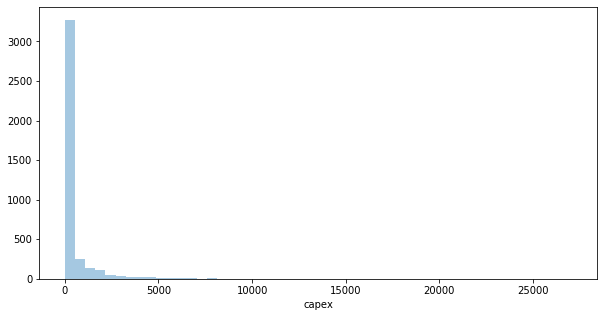

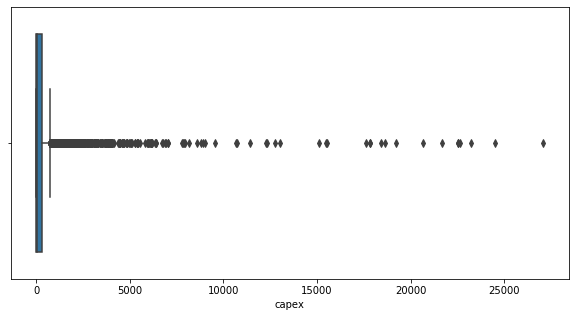

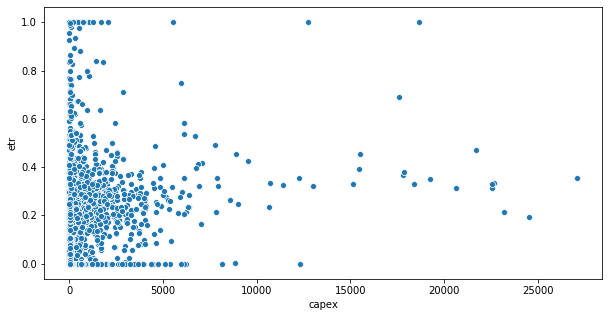

In [58]:
quick_viz(df.capex)

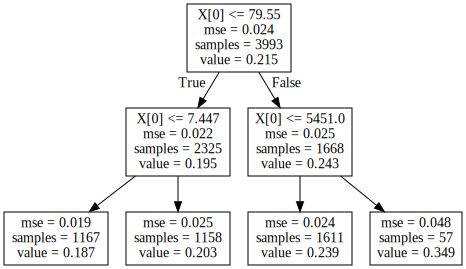

In [59]:
clf = tree.DecisionTreeRegressor(max_depth=2)
clf = clf.fit(np.array(df["capex"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [60]:
df["capex_cat"] = pd.cut(df["capex"],splits)
df_test["capex_cat"] = pd.cut(df_test["capex"],splits)

df = pd.get_dummies(df, columns=["capex_cat"], prefix=["capex_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["capex_cat"], prefix=["capex_cat"], drop_first=True)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 83) (363, 83)
True


**revenue** - discretization using tree

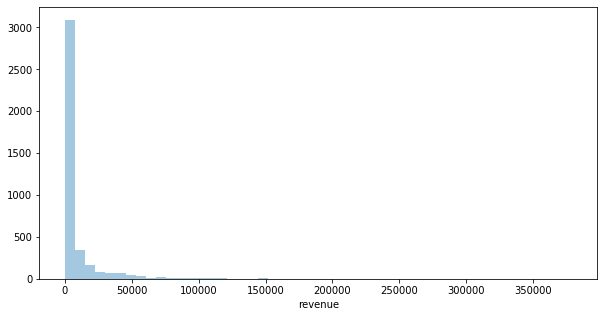

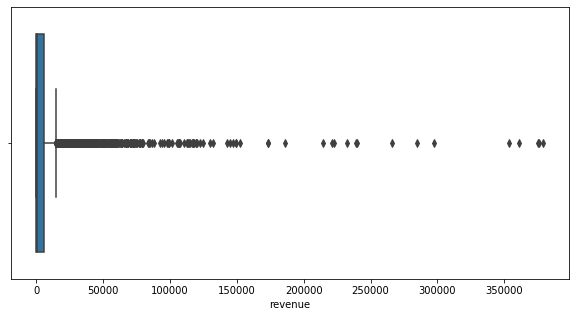

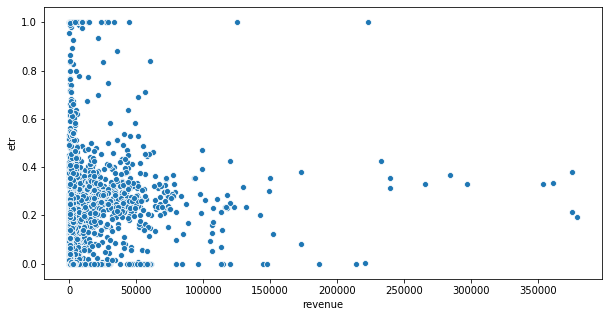

In [61]:
quick_viz(df.revenue)

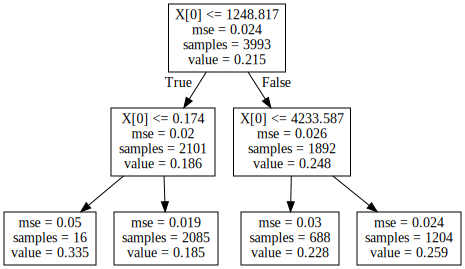

In [62]:
clf = tree.DecisionTreeRegressor(max_depth=2,)
clf = clf.fit(np.array(df["revenue"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)
splits.sort()

In [63]:
df["revenue_cat"] = pd.cut(df["revenue"],splits)
df_test["revenue_cat"] = pd.cut(df_test["revenue"],splits)

df = pd.get_dummies(df, columns=["revenue_cat"], prefix=["revenue_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["revenue_cat"], prefix=["revenue_cat"], drop_first=True)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 86) (363, 86)
True


**cce** - let's use decision tree

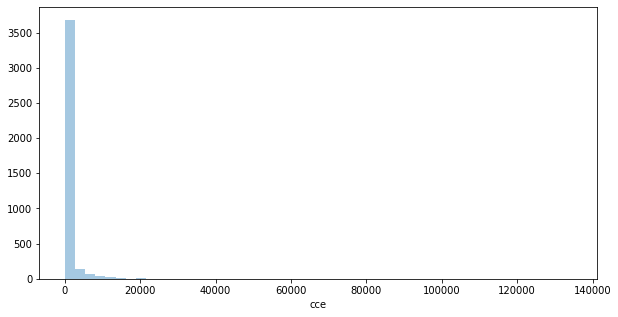

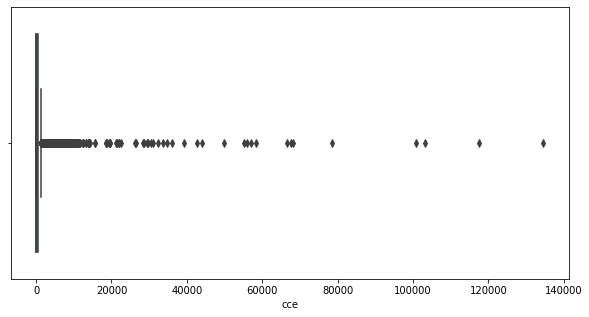

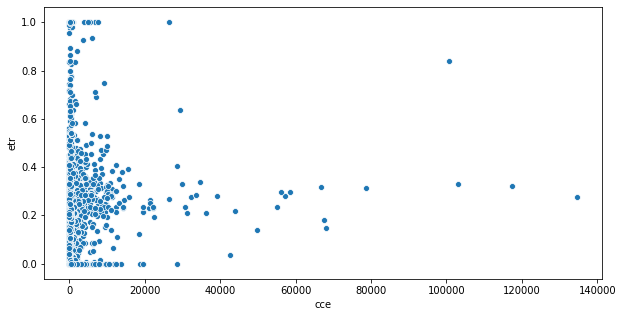

In [64]:
quick_viz(df.cce)

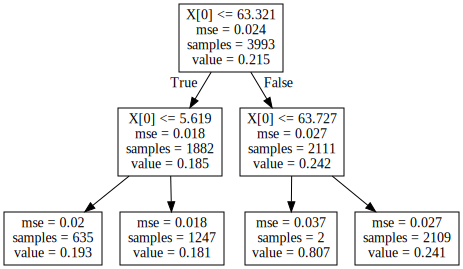

In [65]:
clf = tree.DecisionTreeRegressor(max_depth=2,)
clf = clf.fit(np.array(df["cce"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [66]:
splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)

In [67]:
splits.remove(63.72700119018555)

In [68]:
splits.sort()

In [69]:
df["cce_cat"] = pd.cut(df["cce"],splits)
df_test["cce_cat"] = pd.cut(df_test["cce"],splits)

df = pd.get_dummies(df, columns=["cce_cat"], prefix=["cce_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["cce_cat"], prefix=["cce_cat"], drop_first=True)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 88) (363, 88)
True


**adv** - let's use decision tree

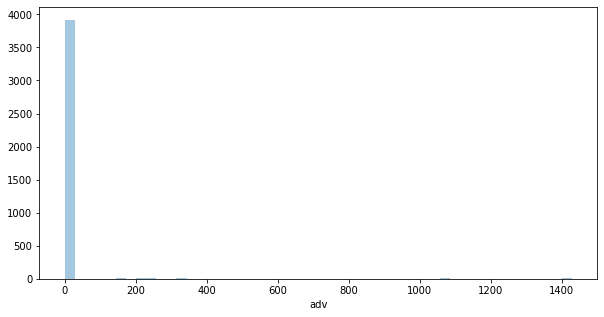

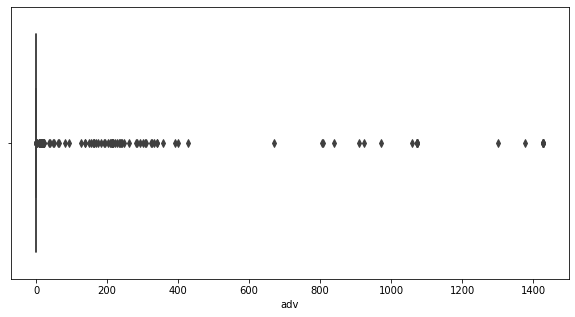

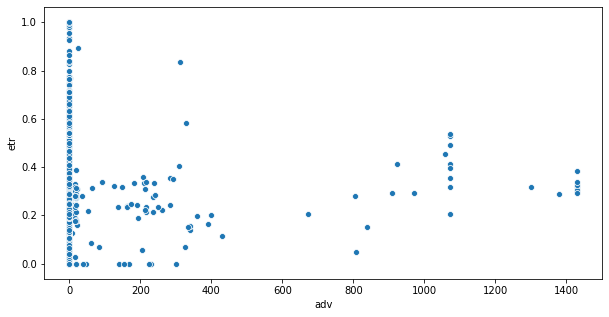

In [71]:
quick_viz(df.adv)

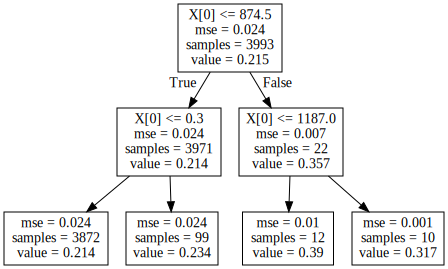

In [72]:
clf = tree.DecisionTreeRegressor(max_depth=2,)
clf = clf.fit(np.array(df["adv"]).reshape(-1, 1), np.array(df.etr).reshape(-1, 1))

export_graphviz(clf, 'tree.dot')
display(graphviz.Source(export_graphviz(clf)))

In [73]:
splits = np.array(clf.tree_.threshold)
splits = splits[splits != -2]
splits = splits.tolist()
splits.append(np.Inf)
splits.append(-np.inf)

In [76]:
splits.remove(1187.0)

In [77]:
splits.sort()

In [80]:
df["adv_cat"] = pd.cut(df["adv"],splits)
df_test["adv_cat"] = pd.cut(df_test["adv"],splits)

df = pd.get_dummies(df, columns=["adv_cat"], prefix=["adv_cat"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["adv_cat"], prefix=["adv_cat"], drop_first=True)

print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 90) (363, 90)
True


**diff** - greater or lower than zero - dichotomous variable

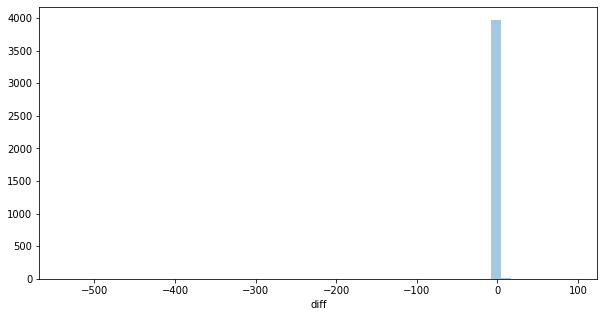

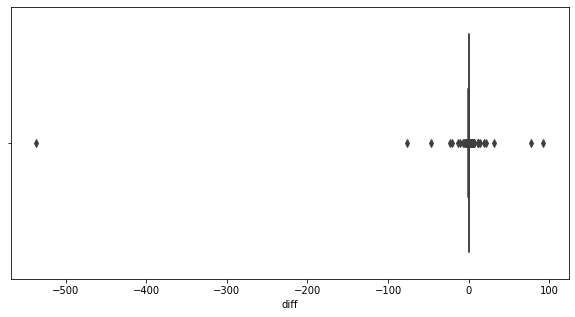

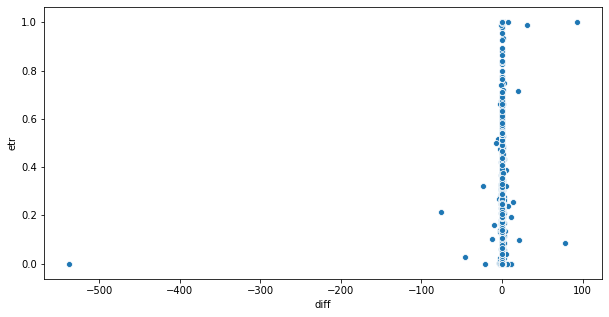

In [92]:
quick_viz(df["diff"])

In [94]:
df["diff_positive"] = df["diff"]>=0
df_test["diff_positive"] = df_test["diff"]>=0

In [95]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 91) (363, 91)
True


**roa** - clipping

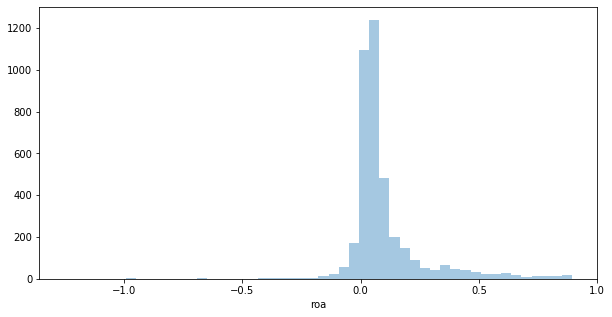

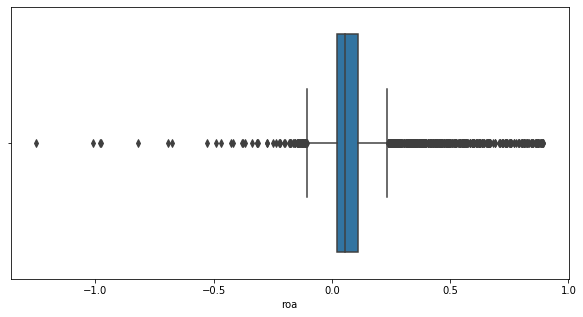

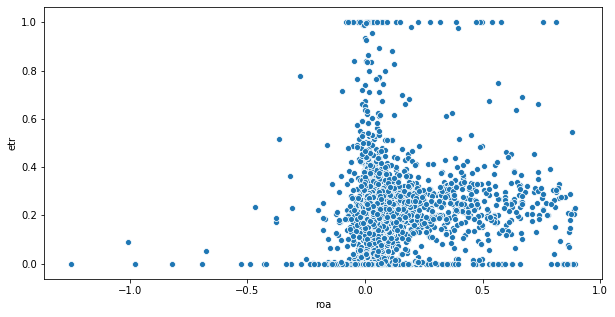

In [99]:
quick_viz(df.roa)

In [104]:
df["roa_clip"] = df.roa.clip(lower=-1)
df_test["roa_clip"] = df_test.roa.clip(lower=-1)

In [105]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 92) (363, 92)
True


**lev** - sqrt

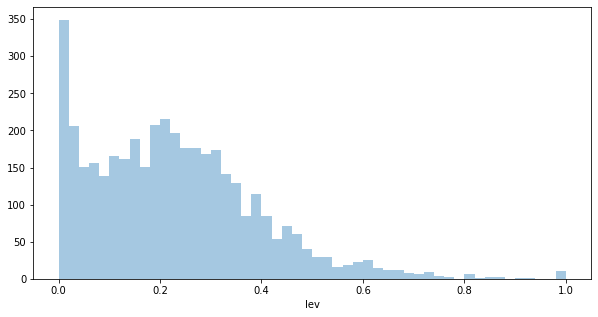

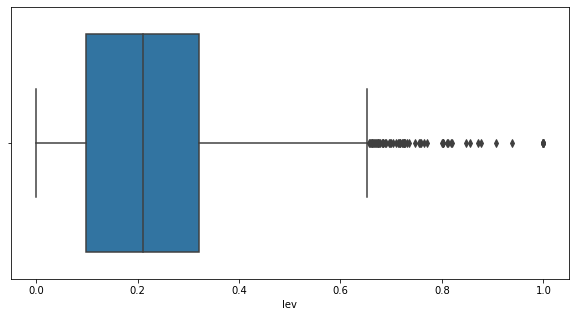

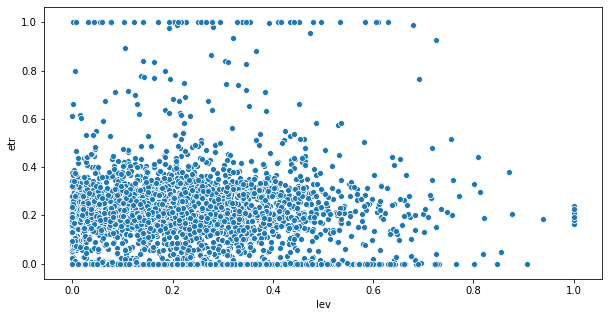

In [101]:
quick_viz(df.lev)

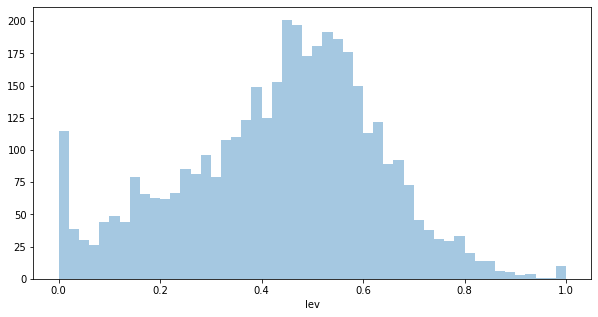

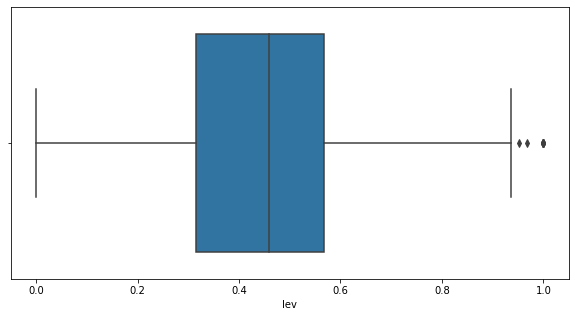

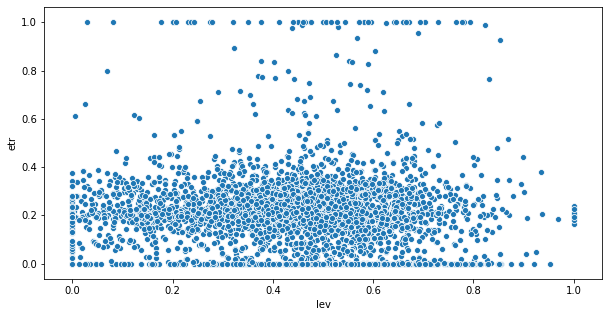

In [103]:
quick_viz(np.sqrt(df.lev))

In [106]:
df["lev_sqrt"] = np.sqrt(df.lev)
df_test["lev_sqrt"] = np.sqrt(df_test.lev)

In [107]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 93) (363, 93)
True


**intan** - pow

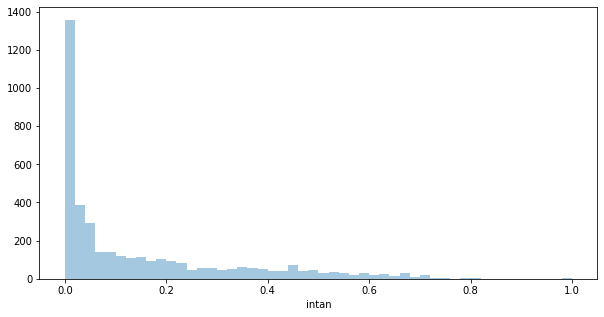

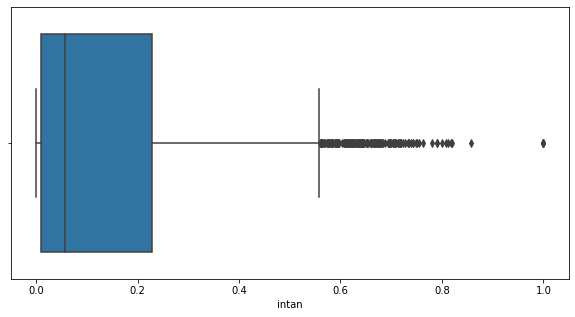

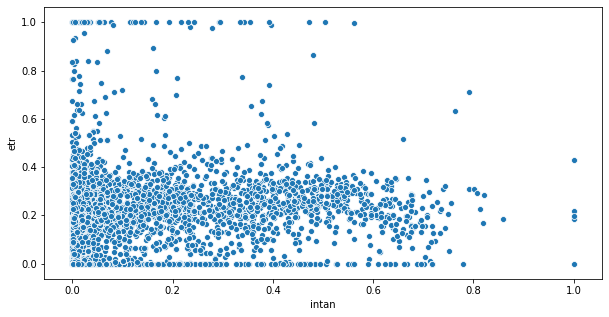

In [111]:
quick_viz(df.intan)

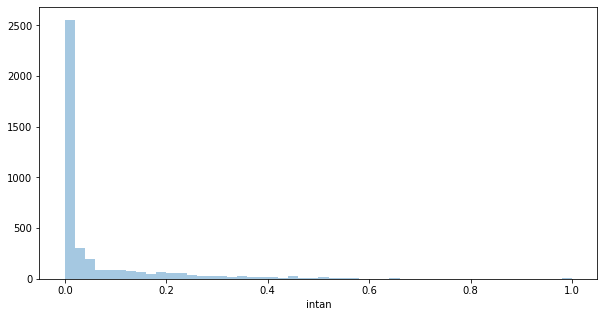

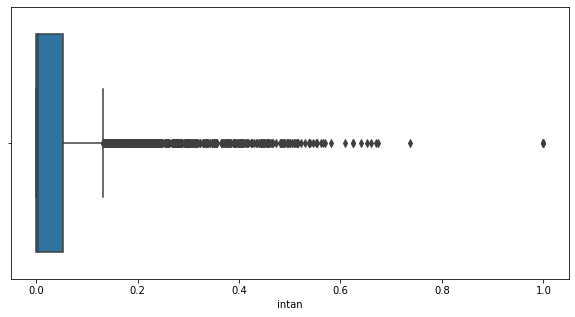

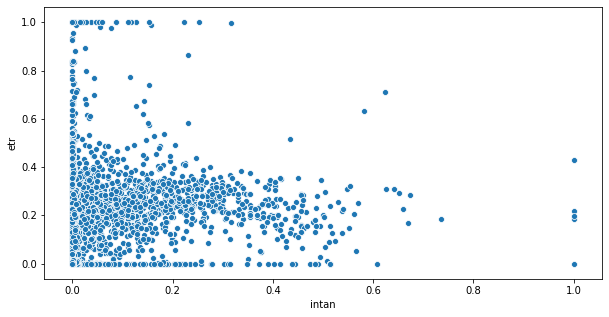

In [112]:
quick_viz(np.power(df.intan,2))

In [113]:
df["intan_pow2"] = np.power(df.intan,2)
df_test["intan_pow2"] = np.power(df_test.intan,2)

In [114]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 94) (363, 94)
True


**rd** - sqrt

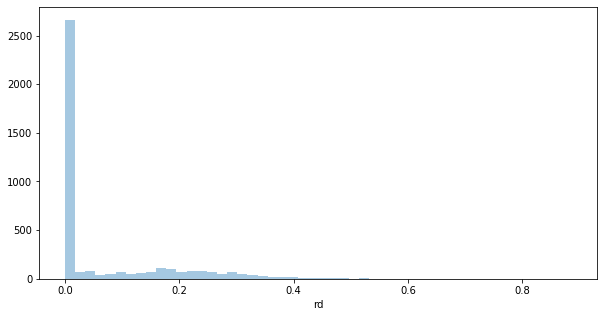

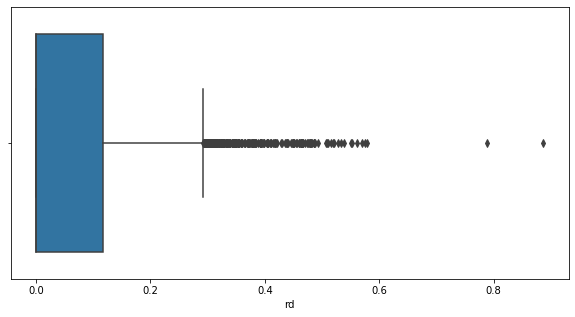

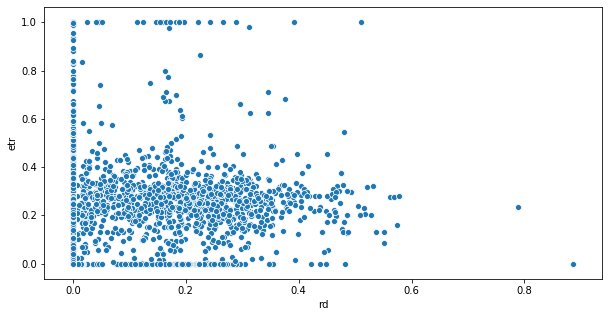

In [116]:
quick_viz(np.sqrt(df.rd))

In [117]:
df["rd_sqrt"] = np.power(df.rd,0.5)
df_test["rd_sqrt"] = np.power(df_test.rd,0.5)

In [118]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 95) (363, 95)
True


**ppe** - clip

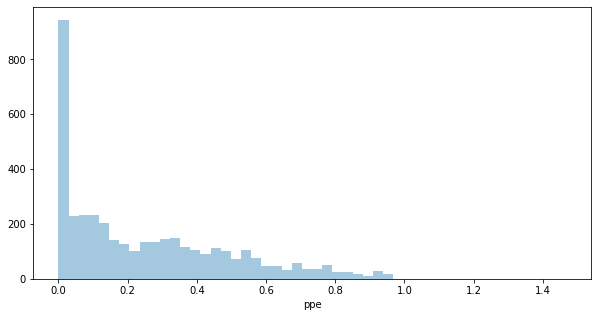

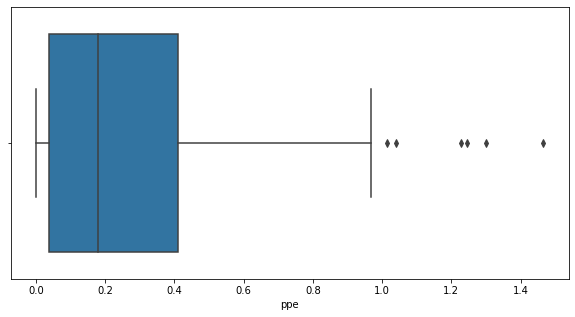

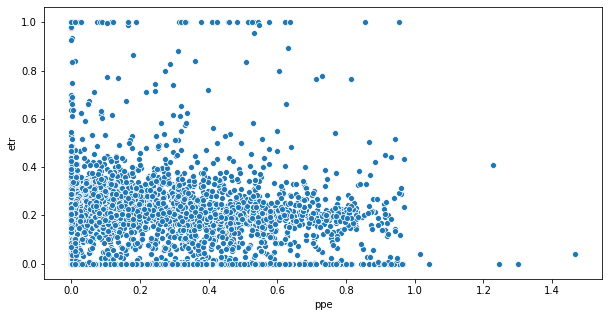

In [125]:
quick_viz(df.ppe)

In [121]:
df['ppe_clip'] = df.ppe.clip(upper=1)
df_test['ppe_clip'] = df_test.ppe.clip(upper=1)

In [122]:
print(df.shape, df_test.shape)
print(all(df.columns == df_test.columns))

(3993, 96) (363, 96)
True


**sale**

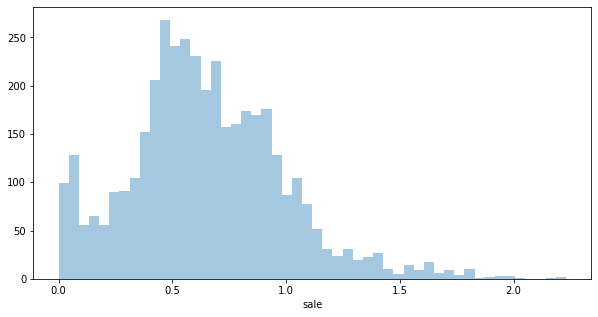

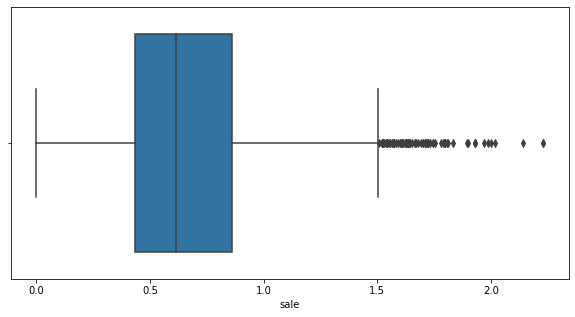

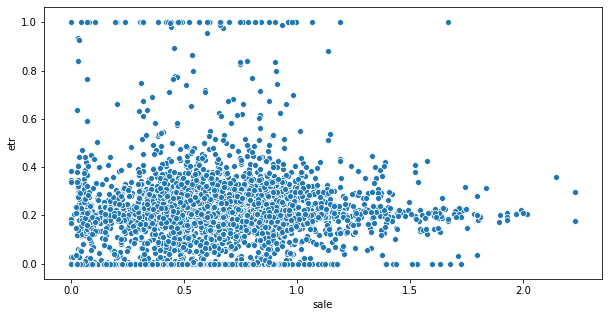

In [127]:
quick_viz(df.sale)

**cash_holdings**

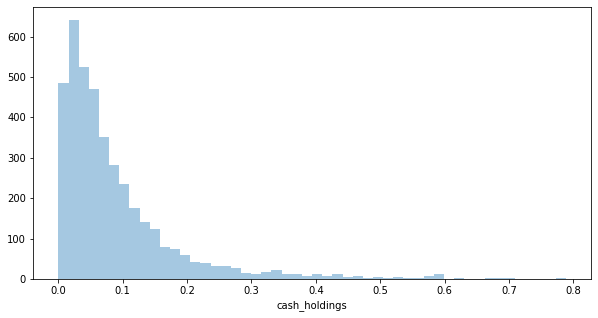

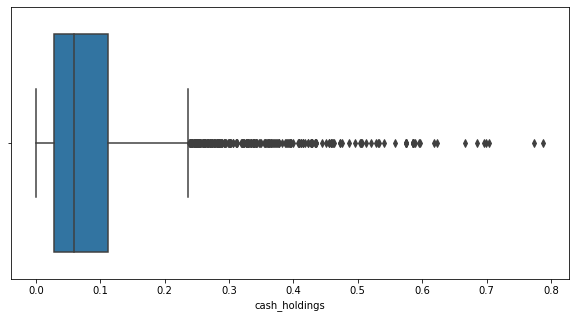

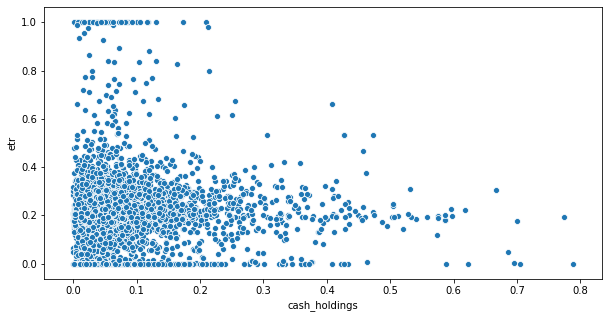

In [128]:
quick_viz(df.cash_holdings)